In [4]:
from io import StringIO
from html.parser import HTMLParser     
        
class StackOverflowParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.strict = False # If any invalid html is encountered, parser will make a best guess at its intention
        self.convert_charrefs= True # Hold data section until next tag is encountered
        
        # Field variable to keep track of parsed data with tags removed
        self.text = StringIO()
        self.text_no_code = StringIO()
        
        # Field variables to keep track of and store <code></code> blocks
        self.code_blocks = []
        self.lasttag = None
        
    def handle_starttag(self, tag, attrs):
        '''
        Method inherited from HTMLParser super class that is called whenever the start of a tag is encountered.
        In this parser, it keeps track of the last start tag that was encountered.
        :param tag: Current tag being parsed (ex: p, div, code, etc.)
        :type tag: str
        :param attrs: List of (name,value) pairs containing attributes found inside the tag's brackets
        :type attrs: list[str]
        '''
        assert isinstance(tag,str)
        assert isinstance(attrs, list) 
        
        self.lasttag = tag
        
    def handle_data(self, data): 
        '''
        Method inherited from HTMLParser super class that is called whenever data inside of a tag is encountered.
        In this parser, it saves blocks of code to the field variable self.code and records all text with HTML tags removed
        :param data: Current data inside of a tag being parsed
        :type tag: str
        '''
        assert isinstance(data,str)
        
        # If the last tag encountered was a <code> tag, append the contents to the list of code blocks
        if self.lasttag == "code":
            self.lasttag = None
            self.code_blocks.append(data)
        else:  
            self.text_no_code.write(data)
            
        # Record text between tags
        self.text.write(data)
        
    def get_data(self):
        '''
        Returns parsed text without HTML tags 
        :return: Text wihtout tags
        :type return: str
        '''
        return self.text.getvalue()
    
    def get_data_no_code(self):
        '''
        Returns parsed text without HTML tags and with code blocks removed
        :return: Text wihtout tags
        :type return: str
        '''
        return self.text_no_code.getvalue()
    
def strip_tags(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the same text with the HTML tags now removed. 
    This method bundles the process of instantiating a parser, feeding the data, and returning the parsed output.
    :param html: HTML-formatted body of text
    :type html: str
    :return: The input text now without HTML tags
    :type return: str
    '''
    assert isinstance(html,str)
    
    # Feed text into parser and return parsed text without tags
    s = StackOverflowParser()
    s.feed(html)
    return s.get_data()

def get_text_no_code(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the same text with the HTML tags and blocks of code now removed. 
    This method bundles the process of instantiating a parser, feeding the data, and returning the parsed output.
    :param html: HTML-formatted body of text
    :type html: str
    :return: The input text now without HTML tags or code blocks
    :type return: str
    '''
    assert isinstance(html,str)
    
    # Feed text into parser and return parsed text without tags
    s = StackOverflowParser()
    s.feed(html)
    return s.get_data_no_code()

def get_code(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the blocks of code found within the text. 
    This method bundles the process of instantiating a parser, feeding the data, and returning the blocks of code.
    An empty list is returned if no <code> tags are found.
    :param html: HTML-formatted body of text
    :type html: str
    :return: List of blocks of code found within text
    :type return: list[str]
    '''
    assert isinstance(html,str)
    
    s = StackOverflowParser()
    s.feed(html) 
    return [item.replace('\n', ' ') for item in s.code_blocks]

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Import the dataset directly from Kaggle 
# Requires a Kaggle account linked to an API key on your device 
api = KaggleApi()
api.authenticate()
api.dataset_download_files('stackoverflow/pythonquestions', path='./', unzip=True)

ModuleNotFoundError: No module named 'kaggle'

In [12]:
import pandas as pd

# File Paths 
file_questions = 'Questions.csv'
file_answers = 'Answers.csv'
file_tags = 'Tags.csv'

dates = ["CreationDate"]

# Load dataframes (only loading first 10000 rows for now to reduce processing time)
questions_df = pd.read_csv(file_questions, encoding = 'iso-8859-1', nrows=10000, parse_dates=dates)
answers_df = pd.read_csv(file_answers, encoding = 'iso-8859-1', nrows=10000, parse_dates=dates)
tags_df = pd.read_csv(file_tags, encoding = 'iso-8859-1', nrows=10000)

In [13]:
# Add extra columns to dataframes
# This takes a long time (~10 minutes) to process the entire dataset
# Might be worth exploring the pandas to_pickle() method for saving/loading the dataframes

questions_df = questions_df.fillna('')
#questions_df['Body_no_tags']=questions_df['Body'].apply(strip_tags)
questions_df['Body_no_tags_no_code']=questions_df['Body'].apply(get_text_no_code)
#questions_df['Body_code']=questions_df['Body'].apply(get_code)

#answers_df['Body_no_tags']=answers_df['Body'].apply(strip_tags)
answers_df['Body_no_tags_no_code']=answers_df['Body'].apply(get_text_no_code)
#answers_df['Body_code']=answers_df['Body'].apply(get_code)

In [14]:
# Creates one database with every question linked to every answer
# For questions with no answer the values are NaN
suffixes = ['.q', '.a']
excess_columns = ['OwnerUserId.q', 'Id.a', 'OwnerUserId.a','ParentId', 'Body.q','CreationDate.a', 'Body.a']
QA_df = questions_df.merge(answers_df, how='left', left_on='Id', right_on='ParentId', suffixes=suffixes).drop(excess_columns , axis=1)

# Merges the questions/answers with all the associated tags 
QAT_df = QA_df.merge(tags_df, how='left', left_on='Id.q', right_on='Id', suffixes=['', '.t']).drop('Id', axis=1)
QAT_df = QAT_df.fillna('')

# Groups all the questions together with a list of all the answers scores and body
# Includes the tags as well 
# Uses a set- might be an issue for pairing the answer scores to the answers
QAT_list = QAT_df.groupby('Id.q').agg(Id=('Id.q', 'max'),
                                      CreationDate=('CreationDate.q', 'max'),
                                      Q_Score=('Score.q', 'mean'),
                                      Title=('Title', 'max'),
                                      Q_Body=('Body_no_tags_no_code.q', 'max'),
                                      A_Score=('Score.a', lambda x: set(x)),
                                      A_Body=('Body_no_tags_no_code.a', lambda x: set(x)),
                                      Tags=('Tag', lambda x: set(x)))
QAT_list.A_Body = QAT_list.A_Body.apply(lambda s: ' '.join(s)) # Turns the set of Answers into a str

In [15]:
# Filtering out certain questions
QAT_list.iloc[0]['A_Body']

"open up a terminal (Applications->Utilities->Terminal) and type this in:\r\n\r\n\r\n\r\nThis will spit out every file that has the name you want.\r\n\r\nWarning: there may be alot to wade through. There must be a method in Cocoa to get a list of fonts, then you would have to use the PyObjC bindings to call it..\n\nDepending on what you need them for, you could probably just use something like the following..\n\n\n I haven't been able to find anything that does this directly.  I think you'll have to iterate through the various font folders on the system: , , and there can probably be a user-level directory as well .\n Unfortunately the only API that isn't deprecated is located in the ApplicationServices framework, which doesn't have a bridge support file, and thus isn't available in the bridge. If you're wanting to use ctypes, you can use ATSFontGetFileReference after looking up the ATSFontRef.\r\n\r\nCocoa doesn't have any native support, at least as of 10.5, for getting the location 

In [16]:
# Creates one database with every question linked to every answer
# Questions with no answers are dropped
QA_df = questions_df.merge(answers_df, how='right', left_on='Id', right_on='ParentId', suffixes=suffixes).drop(excess_columns , axis=1)
QAT_df = QA_df.merge(tags_df, how='left', left_on='Id.q', right_on='Id', suffixes=['', '.t']).drop('Id', axis=1)

In [17]:
# Row 11 in Questions.csv is a good example with a few code blocks
body = questions_df['Body'][11]
body_no_tags = questions_df['Body_no_tags'][11]
body_code = questions_df['Body_code'][11]
body_no_tags_no_code = questions_df['Body_no_tags_no_code'][11]

KeyError: 'Body_no_tags'

In [ ]:
print(body)

In [ ]:
print(questions_df)

In [ ]:
print(body_no_tags_no_code)

In [ ]:
print(body_code)

In [ ]:
questions=questions_df['Body_no_tags_no_code']

In [ ]:
QAT_list=QAT_list.values.tolist() # Insert QAT_list into list
QAT_list

In [ ]:
import numpy as np
import seaborn as sns # Import seaborn for visualization
import matplotlib.pyplot as plt
sns.set()

In [ ]:
import nltk # Import natural language toolkit library
nltk.download('stopwords')
import pyLDAvis #Import pyLDAvis for interactive visualization
import pyLDAvis.gensim
import gensim #Import gensim for topic modelling 
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

try:
    import spacy #Import Spacy for lemmatization
    from scipy.sparse.sparsetools.csr import _csr

except:
    from scipy.sparse import sparsetools as _csr


In [ ]:
# Create bigram and trigram sequences
bigram = gensim.models.Phrases(QAT_list, min_count=20, threshold=100) 
trigram = gensim.models.Phrases(bigram[QAT_list], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
import en_core_web_sm  #English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
nlp = en_core_web_sm.load()

In [ ]:
# Load tagger
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk fro preprocessing
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'VERB']):
    
    """
    Transform the  questions into lowercase, build bigrams-trigrams, and apply lemmatization

    """
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [ ]:
processed_data = process_words(QAT_list) #Apply processing functions to the list
processed_data

In [ ]:
id2word = corpora.Dictionary(processed_data) # Create dictionary of the words 
print('Vocabulary Size:', len(id2word))

In [ ]:
corpus = [id2word.doc2bow(text) for text in processed_data] #Create Corpus tuple (BoW format) containing the each word id and their frequency


In [ ]:
#Create dictionary and dataframe of Corpus to remove the high frequncy words 
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [ ]:
dict_df

In [ ]:
# Plot histogram of word frequency 
plt.figure(figsize=(8,6))
sns.histplot(dict_df['freq'], bins=100);

In [ ]:
#Top 25 high-frequency words
dict_df2=dict_df.sort_values('freq', ascending=False).head(25) 

In [ ]:
dict_df2

In [ ]:
# Filter out high-frequancy words based on the pre-defined threshold
extension = dict_df[dict_df.freq>598438].index.tolist()


In [ ]:
# List of other non-relevant words identified by inspection that need to be filterd out
unrelevant=['problem','reason','luck','book','purpose','nose','clue','happen','scucceed','reason','thought','oppose','hope','realize','cheer','want','example','laptop','guy','look','need','write', 'walk','good', 'lot', 'people', 'great','please','wikipedia','fun','movie', 'problem', 'answer','thank','need', 'question', 'thing','suggest','solution', 'wrong', 'prefer', 'mention', 'correctly', 'good', 'easy', 'follow', 'great', 'feel', 'idea', 'recommend', 'support','want','look','way','pretty', 'result', 'basic', 'give', 'bad', 'nice', 'try', 'well', 'write', 'look']

In [ ]:
# Add non-relevant words to high-frequncy words
extension.extend(unrelevant)

In [ ]:
# Add high-frequency and nor-relevant words to stop words list
stop_words.extend(extension)
# Rerun the word processing function
processed_data= process_words(QAT_list)
# Recreate Dictionary
id2word = corpora.Dictionary(processed_data)
print('New Vocabulary Size:', len(id2word))

In [ ]:
# Filter out words that occur on less than 10 questions, or on more than 60% of the questions.
id2word.filter_extremes(no_below=10, no_above=0.6)
print('Total Vocabulary Size:', len(id2word))

In [ ]:
# Update the corpus 
corpus = [id2word.doc2bow(text) for text in processed_data]

In [ ]:
import pickle
pickle.dump(corpus, open("corpus_100_QAT.pkl", "wb")) #Pickle the corpus and id2word to restart the kernel with fresh memory
pickle.dump(id2word, open("id2word_100_QAT.pkl", "wb"))

In [ ]:
import os
from gensim.models.wrappers import LdaMallet  # Import Mallet LDA
num_topics=100 # Number of Topics

# Path to Mallet Change to correct path
os.environ['MALLET_HOME'] = '\\Users\\hamed\\mallet-2.0.8' 
mallet_path = '\\Users\\hamed\\mallet-2.0.8\\bin\\mallet'

In [ ]:
# Built the topic model using Mallet LDA implementation
ldamallet =gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

In [ ]:
# Print the topics compiled by the model and diplay 5 term and their relative weights
from pprint import pprint
pprint(ldamallet.show_topics(num_words=5,formatted=False))

In [ ]:
# Compute the Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=processed_data, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

In [ ]:
import pickle
corpus = pickle.load(open("corpus_100_QAT.pkl", "rb"))
id2word = pickle.load(open("id2word_100_QAT.pkl", "rb"))

In [ ]:
# Build another model using multicore LDA implementation and compare the coherence score
from gensim.models import LdaMulticore
ldamulticore = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word,workers=4, eval_every=None, passes=20, batch=True,per_word_topics=True)

In [ ]:
# Display topics
from pprint import pprint
pprint(ldamulticore.show_topics(num_words=5,formatted=False))

In [ ]:
# Compute Coherence Score for the multicore model
processed_data = pickle.load(open("processed_data_100_QAT.pkl", "rb"))
coherence_model_ldamulticore = CoherenceModel(model=ldamulticore, texts=processed_data, dictionary=id2word, coherence='c_v')
coherence_ldamulticore = coherence_model_ldamulticore.get_coherence()
print('Coherence Score: ', coherence_ldamulticore)

In [ ]:
# Build another model using LDA implementation and compare the coherence score with the two previous models
from gensim.models import LdaModel
ldamodel = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, eval_every=None, passes=20,per_word_topics=True)

In [ ]:
# Display topics
pprint(ldamodel.show_topics(num_words=5,formatted=False))

In [ ]:
# Compute Coherence Score
coherence_model_ldamodel = CoherenceModel(model=ldamodel, texts=processed_data, dictionary=id2word, coherence='c_v')
coherence_ldamodel = coherence_model_ldamodel.get_coherence()
print('Coherence Score: ', coherence_ldamodel)

In [ ]:
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models using plotly. The chart will be interactive"""
    import plotly.graph_objs as go
    import plotly.offline as py

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

In [ ]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """ function to plot difference between modelsUses using matplotlib"""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)
try:
    get_ipython()
    import plotly.offline as py
except Exception:

    plot_difference = plot_difference_matplotlib
    
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly


In [ ]:
# Heatmap to compare the correlation between LDA and Multicore LDA
mdiff, annotation = ldamodel.diff(ldamulticore, distance='jaccard', num_words=30)
plot_difference(mdiff, title="LDA vs LDA Multicore Topic difference by Jaccard distance", annotation=annotation)

In [ ]:
# Convert LdaMallet model to a gensim model for Visualization

from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [ ]:
# Heatmap to compare the correlation between LDA and Multicore LDA
mdiff, annotation = ldagensim.diff(ldamulticore, distance='jaccard', num_words=30)
plot_difference(mdiff, title="LDA Mallet vs LDA Multicore Topic difference by Jaccard distance", annotation=annotation)

In [ ]:
# Get the topic distributions by passing in the corpus to the model
tm_results = ldamallet[corpus]

In [ ]:
# Get the most dominant topic
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [ ]:
# Get top  significant terms and their probabilities for each topic using ldamallet
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

In [ ]:
# Get top  significant terms and their probabilities for each topic using LDA multicore
topics_ldamulticore = [[(term, round(wt, 3)) for term, wt in ldamulticore.show_topic(n, topn=20)] for n in range(0, ldamulticore.num_topics)]

In [ ]:
import pickle
from gensim.models import CoherenceModel
ldamodel = pickle.load(open("\\Users\\hamed\\Desktop\\ECE 143 Project Data Files\\ldamodel_100_QAT.pkl", "rb"))
ldamulticore = pickle.load(open("\\Users\\hamed\\Desktop\\ECE 143 Project Data Files\\ldamulticore_100_QAT.pkl", "rb"))

In [ ]:
# Get top  significant terms and their probabilities for each topic using LDA multicore
topics_ldam = [[(term, round(wt, 3)) for term, wt in ldamodel.show_topic(n, topn=20)] for n in range(0, ldamodel.num_topics)]

In [ ]:
# 5 most probable words for each topic for LDA 
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics_ldamulticore], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamulticore.num_topics+1)]).T
topics_df.head()

In [ ]:
# 5 most probable words for each topic for LDA  
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, topics.num_topics+1)]).T
topics_df.head()

In [ ]:
# Display all the terms for each topic for LDA Mallet
#pd.set_option('display.max_colwidth', -1)
#topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
#topics_df

In [ ]:
# Display all the terms for each topic for LDA Multicore
pd.set_option('display.max_colwidth', -1)
topics_df_ldam = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics_ldamulticore], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamulticore.num_topics+1)] )
topics_df_ldam

In [ ]:
# Display all the terms for each topic for LDA 
import pandas as pd
pd.set_option('display.max_colwidth', -1)
topics_df_lda = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics_ldam], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamodel.num_topics+1)] )
topics_df_lda

In [ ]:
# Visualize the LDA Mallet terms as wordclouds
from wordcloud import WordCloud # Import wordclouds

# Initiate the wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(25):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 5, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [ ]:
# Visualize the LDA Multicore terms as wordclouds
from wordcloud import WordCloud # Import wordclouds

# Initiate the wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]
plt.title("LDA Multicore Output")


# Create subplots for each topic
for i in range(25):
    wc.generate(text=topics_df_ldam["Terms per Topic"][i])
    plt.subplot(5, 5, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df_ldam.index[i])
plt.show()


In [ ]:
# Visualize the LDA terms as wordclouds
from wordcloud import WordCloud # Import wordclouds

# Initiate the wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]
plt.title("LDA Output")
startoffset = 25
# Create subplots for each topic
for i in range(25):
    wc.generate(text=topics_df_lda["Terms per Topic"][i+startoffset])
    plt.subplot(5, 5, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df_lda.index[i])

plt.show()

In [ ]:
# Visualize the LDA terms as wordclouds
from wordcloud import WordCloud # Import wordclouds

# Initiate the wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [10, 5]
plt.title("LDA Output")

# Create subplots for each topic

wc.generate(text=topics_df_ldam["Terms per Topic"][75])
plt.subplot(1, 1, 1)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

plt.show()

In [ ]:
import pyLDAvis.gensim as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

In [ ]:
import pyLDAvis.gensim as gensimvis
vis_data = gensimvis.prepare(ldamulticore, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

In [ ]:
import pyLDAvis.gensim as gensimvis
vis_data = gensimvis.prepare(ldamodel, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

In [ ]:
import pickle #picke the result for later use
pickle.dump(processed_data, open("processed_data_100_QAT.pkl", "wb"))
pickle.dump(ldamulticore, open("ldamulticore_100_QAT.pkl", "wb"))
pickle.dump(ldamodel, open("ldamodel_100_QAT.pkl", "wb"))

In [ ]:
import pickle #Unpickle the previous results
from gensim.models import CoherenceModel
corpus = pickle.load(open("C:\\Users\\hamed\\Desktop\\ECE 143 Project Data Files\\corpus_100_QAT.pkl", "rb"))
id2word = pickle.load(open("C:\\Users\\hamed\\Desktop\\ECE 143 Project Data Files\\id2word_100_QAT.pkl", "rb"))
processed_data = pickle.load(open("C:\\Users\\hamed\\Desktop\\ECE 143 Project Data Files\\processed_data_100_QAT.pkl", "rb"))

In [ ]:
import pyLDAvis.gensim as gensimvis
vis_data = gensimvis.prepare(ldamodel, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

In [ ]:
import pyLDAvis #Import pyLDAvis for interactive visualization
pyLDAvis.display(vis_data)

In [ ]:
import pyLDAvis # Save the interactive 
pyLDAvis.save_html(vis_data, "C:\\Users\\hamed\\Desktop\\ECE 143 Project Data Files\\lda_visulaization_100.html")

In [ ]:
# Visualization of "Tags" distribution
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import collections
from collections import OrderedDict
file_tags = 'C:\\Users\\hamed\\Desktop\\ECE 143 Project Data Files\\Tags.csv'
Tags_r = pd.read_csv(file_tags, engine ='python',usecols = ['Tag'], encoding = 'iso-8859-1',error_bad_lines=False)
tags_count = collections.Counter(Tags)
common_tags = OrderedDict(tags_count.most_common(18))
del common_tags['python'] # remove non-infomative tags
del common_tags['python-2.7']
del common_tags['python-3.x']
labels, values = zip(*common_tags.items())
values = [v/1000 for v in values] # Change the frequency to thousends
s = pd.Series(
   values, labels
)
plt.figure(figsize=(80,30))

ax = s.plot.bar(x="labels", y="values", rot=0,color=[(174/255,199/255,232/255)])
plt.title('Top 15 Most Frequent Tags \n', fontsize=60,fontfamily='Nunito')
plt.xlabel('\nTags', fontsize=55,fontfamily='Nunito')
plt.ylabel('   Frequency \n (thousands)\n ', fontsize=55,fontfamily='Nunito')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
from matplotlib import rcParams
plt.rcParams.update({'font.size': 40,'font.family':'Nunito'})
rects = ax.patches
# Make some labels.

labels = ['62.8k','26.8k','25.8k','18.9k','16.5k','14k','13.4k','10.7k','10.6k','10.4k','10.2k','9.3k','9.1k','8k','7.5k']

# Add labels on top of the bars
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom')    
plt.show()


In [ ]:
# Compute coherance score for different topic values
lda_models, coherence_scores = topic_model_coherence_generator(corpus=corpus, texts=processed_data, dictionary=id2word, start_topic_count=25, end_topic_count=150, step=25)

In [ ]:
import gensim #Import gensim for topic modelling 
import gensim.corpora as corpora
from gensim.models import LdaModel
import os
format =".pkl"

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=25, end_topic_count=125, step=25):
    """Get the coherance score for differnt topic values from 25 and 150"""
  models = []
  coherence_scores = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    ldamodel = LdaModel(corpus=corpus, num_topics=topic_nums, id2word=id2word, eval_every=None, passes=20,per_word_topics=True)
    dir_name="C:\\Users\\hamed\\OneDrive\\Desktop\\ECE 143 Project Data Files\\"
    save_dir=os.path.join(dir_name, "ldamodel_"+ str(topic_nums) +"_QAT_3_7" + format)
    pickle.dump(ldamodel, open(save_dir, "wb"))
    
    cv_coherence_model_lda = gensim.models.CoherenceModel (model=ldamodel, corpus=corpus, texts=texts,
                                                                     dictionary=dictionary, coherence='c_v')
      
    coherence_score = cv_coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)
    models.append(ldamodel)
  return models, coherence_scores  

In [18]:
from io import StringIO
from html.parser import HTMLParser     
        
class StackOverflowParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.strict = False # If any invalid html is encountered, parser will make a best guess at its intention
        self.convert_charrefs= True # Hold data section until next tag is encountered
        
        # Field variable to keep track of parsed data with tags removed
        self.text = StringIO()
        self.text_no_code = StringIO()
        
        # Field variables to keep track of and store <code></code> blocks
        self.code_blocks = []
        self.lasttag = None
        
    def handle_starttag(self, tag, attrs):
        '''
        Method inherited from HTMLParser super class that is called whenever the start of a tag is encountered.
        In this parser, it keeps track of the last start tag that was encountered.
        :param tag: Current tag being parsed (ex: p, div, code, etc.)
        :type tag: str
        :param attrs: List of (name,value) pairs containing attributes found inside the tag's brackets
        :type attrs: list[str]
        '''
        assert isinstance(tag,str)
        assert isinstance(attrs, list) 
        
        self.lasttag = tag
        
    def handle_data(self, data): 
        '''
        Method inherited from HTMLParser super class that is called whenever data inside of a tag is encountered.
        In this parser, it saves blocks of code to the field variable self.code and records all text with HTML tags removed
        :param data: Current data inside of a tag being parsed
        :type tag: str
        '''
        assert isinstance(data,str)
        
        # If the last tag encountered was a <code> tag, append the contents to the list of code blocks
        if self.lasttag == "code":
            self.lasttag = None
            self.code_blocks.append(data)
        else:  
            self.text_no_code.write(data)
            
        # Record text between tags
        self.text.write(data)
        
    def get_data(self):
        '''
        Returns parsed text without HTML tags 
        :return: Text wihtout tags
        :type return: str
        '''
        return self.text.getvalue()
    
    def get_data_no_code(self):
        '''
        Returns parsed text without HTML tags and with code blocks removed
        :return: Text wihtout tags
        :type return: str
        '''
        return self.text_no_code.getvalue()
    
def strip_tags(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the same text with the HTML tags now removed. 
    This method bundles the process of instantiating a parser, feeding the data, and returning the parsed output.
    :param html: HTML-formatted body of text
    :type html: str
    :return: The input text now without HTML tags
    :type return: str
    '''
    if not isinstance(html,str):
        #print(html)
        html = 'NAN' 
    #assert isinstance(html,str)
    
    # Feed text into parser and return parsed text without tags
    s = StackOverflowParser()
    s.feed(html)
    return s.get_data()

def get_text_no_code(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the same text with the HTML tags and blocks of code now removed. 
    This method bundles the process of instantiating a parser, feeding the data, and returning the parsed output.
    :param html: HTML-formatted body of text
    :type html: str
    :return: The input text now without HTML tags or code blocks
    :type return: str
    '''
    assert isinstance(html,str)
    
    # Feed text into parser and return parsed text without tags
    s = StackOverflowParser()
    s.feed(html)
    return s.get_data_no_code()

def get_code(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the blocks of code found within the text. 
    This method bundles the process of instantiating a parser, feeding the data, and returning the blocks of code.
    An empty list is returned if no <code> tags are found.
    :param html: HTML-formatted body of text
    :type html: str
    :return: List of blocks of code found within text
    :type return: list[str]
    '''
    assert isinstance(html,str)
    
    s = StackOverflowParser()
    s.feed(html) 
    return [item.replace('\n', ' ') for item in s.code_blocks]

In [19]:
import pandas as pd

# File Paths 
file_questions = 'Questions.csv'
file_answers = 'Answers.csv'
file_tags = 'Tags.csv'

dates = ["CreationDate"]

# Load dataframes (only loading first 10000 rows for now to reduce processing time)
questions_df = pd.read_csv(file_questions, encoding = 'iso-8859-1', nrows=10000, parse_dates=dates)
answers_df = pd.read_csv(file_answers, encoding = 'iso-8859-1', nrows=1000, parse_dates=dates)
tags_df = pd.read_csv(file_tags, encoding = 'iso-8859-1', nrows=1000)

In [20]:
# Add extra columns to dataframes
# This takes a long time (~10 minutes) to process the entire dataset
# Might be worth exploring the pandas to_pickle() method for saving/loading the dataframes

#questions_df.drop(questions_df.iloc[:, 6:22], inplace = True, axis = 1)   #ignore
questions_df = questions_df.fillna('')                                    #Fill nans with empty string
answers_df = answers_df.fillna('') 

questions_df['Body_no_tags']=questions_df['Body'].apply(strip_tags)
questions_df['Body_no_tags_no_code']=questions_df['Body'].apply(get_text_no_code)
questions_df['Body_code']=questions_df['Body'].apply(get_code)

answers_df['Body_no_tags']=answers_df['Body'].apply(strip_tags)
answers_df['Body_no_tags_no_code']=answers_df['Body'].apply(get_text_no_code)
answers_df['Body_code']=answers_df['Body'].apply(get_code)

In [21]:
#questions_df = questions_df.drop(questions_df.ix[:, '6':'21'].columns, axis = 1) 
questions_df
#answers_df

,Id,OwnerUserId,CreationDate,Score,Title,Body,Body_no_tags,Body_no_tags_no_code,Body_code
0,469,147.0,2008-08-02 15:11:16+00:00,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,I am using the Photoshop's javascript API to f...,I am using the Photoshop's javascript API to f...,[]
1,502,147.0,2008-08-02 17:01:58+00:00,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,I have a cross-platform (Python) application w...,I have a cross-platform (Python) application w...,[]
2,535,154.0,2008-08-02 18:43:54+00:00,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,I'm starting work on a hobby project with a py...,I'm starting work on a hobby project with a py...,[]
3,594,116.0,2008-08-03 01:15:08+00:00,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,There are several ways to iterate over a resul...,There are several ways to iterate over a resul...,[]
4,683,199.0,2008-08-03 13:19:16+00:00,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,I don't remember whether I was dreaming or not...,I don't remember whether I was dreaming or not...,"[foo in iter_attr(array of python objects, att..."
...,...,...,...,...,...,...,...,...,...
9995,1513038,1899246.0,2009-10-03 07:04:43+00:00,0,Deploying a web service to my Google App Engin...,<p>We made a simple application and using Goog...,We made a simple application and using GoogleA...,We made a simple application and using GoogleA...,[]
9996,1513155,31610.0,2009-10-03 08:06:23+00:00,2,Is there a portable way of finding if a path i...,<p>Is there some built-in function that tells ...,Is there some built-in function that tells me ...,Is there some built-in function that tells me ...,[]
9997,1513436,123927.0,2009-10-03 10:33:33+00:00,3,What should I use instead of assignment-in-an-...,"<p>according to <a href=""http://pyfaq.infogami...",according to this page one can't use code like...,according to this page one can't use code like...,[if variable = something(): #do something with...
9998,1513543,183430.0,2009-10-03 11:40:18+00:00,0,verifiedEmail AOL OpenID,<p>I can't seem to fetch the verifiedEmail fie...,I can't seem to fetch the verifiedEmail field ...,I can't seem to fetch the verifiedEmail field ...,[]


In [22]:
# Creates one database with every question linked to every answer
# For questions with no answer the values are NaN
suffixes = ['.q', '.a']
excess_columns = ['OwnerUserId.q', 'Id.a', 'OwnerUserId.a','ParentId']
QA_df = questions_df.merge(answers_df, how='left', left_on='Id', right_on='ParentId', suffixes=suffixes).drop(excess_columns , axis=1);
QA_df.merge(tags_df, how='left', left_on='Id.q', right_on='Id', suffixes=['', '.t']).drop('Id', axis=1);
QA_df

,Id.q,CreationDate.q,Score.q,Title,Body.q,Body_no_tags.q,Body_no_tags_no_code.q,Body_code.q,CreationDate.a,Score.a,Body.a,Body_no_tags.a,Body_no_tags_no_code.a,Body_code.a
0,469,2008-08-02 15:11:16+00:00,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,I am using the Photoshop's javascript API to f...,I am using the Photoshop's javascript API to f...,[],2008-08-02 16:56:53+00:00,4.0,<p>open up a terminal (Applications-&gt;Utilit...,open up a terminal (Applications->Utilities->T...,open up a terminal (Applications->Utilities->T...,[locate InsertFontHere]
1,469,2008-08-02 15:11:16+00:00,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,I am using the Photoshop's javascript API to f...,I am using the Photoshop's javascript API to f...,[],2008-08-02 17:42:28+00:00,2.0,<p>I haven't been able to find anything that d...,I haven't been able to find anything that does...,I haven't been able to find anything that does...,"[/System/Library/Fonts, /Library/Fonts, ~/Libr..."
2,469,2008-08-02 15:11:16+00:00,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,I am using the Photoshop's javascript API to f...,I am using the Photoshop's javascript API to f...,[],2008-08-06 03:01:23+00:00,12.0,<p>Unfortunately the only API that isn't depre...,Unfortunately the only API that isn't deprecat...,Unfortunately the only API that isn't deprecat...,[]
3,502,2008-08-02 17:01:58+00:00,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,I have a cross-platform (Python) application w...,I have a cross-platform (Python) application w...,[],2008-08-02 18:49:07+00:00,9.0,<p>You can use ImageMagick's convert utility f...,You can use ImageMagick's convert utility for ...,You can use ImageMagick's convert utility for ...,"[Convert taxes.pdf taxes.jpg , convert -size ..."
4,502,2008-08-02 17:01:58+00:00,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,I have a cross-platform (Python) application w...,I have a cross-platform (Python) application w...,[],2008-08-10 07:10:19+00:00,2.0,<p>Is the PC likely to have Acrobat installed?...,Is the PC likely to have Acrobat installed? I ...,Is the PC likely to have Acrobat installed? I ...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10716,1513038,2009-10-03 07:04:43+00:00,0,Deploying a web service to my Google App Engin...,<p>We made a simple application and using Goog...,We made a simple application and using GoogleA...,We made a simple application and using GoogleA...,[],NaT,NaN,NaN,NaN,NaN,NaN
10717,1513155,2009-10-03 08:06:23+00:00,2,Is there a portable way of finding if a path i...,<p>Is there some built-in function that tells ...,Is there some built-in function that tells me ...,Is there some built-in function that tells me ...,[],NaT,NaN,NaN,NaN,NaN,NaN
10718,1513436,2009-10-03 10:33:33+00:00,3,What should I use instead of assignment-in-an-...,"<p>according to <a href=""http://pyfaq.infogami...",according to this page one can't use code like...,according to this page one can't use code like...,[if variable = something(): #do something with...,NaT,NaN,NaN,NaN,NaN,NaN
10719,1513543,2009-10-03 11:40:18+00:00,0,verifiedEmail AOL OpenID,<p>I can't seem to fetch the verifiedEmail fie...,I can't seem to fetch the verifiedEmail field ...,I can't seem to fetch the verifiedEmail field ...,[],NaT,NaN,NaN,NaN,NaN,NaN


In [23]:
# Creates one database with every question linked to every answer
# Questions with no answers are dropped
QA_df = questions_df.merge(answers_df, how='right', left_on='Id', right_on='ParentId', suffixes=suffixes).drop(excess_columns , axis=1);
QAT_df = QA_df.merge(tags_df, how='left', left_on='Id.q', right_on='Id', suffixes=['', '.t']).drop('Id', axis=1);
QAT_df;

In [24]:
# Row 11 in Questions.csv is a good example with a few code blocks
body = questions_df['Body'][11]
body_no_tags = questions_df['Body_no_tags'][11]
body_code = questions_df['Body_code'][11]
body_no_tags_no_code = questions_df['Body_no_tags_no_code'][11]

In [25]:
print(body)
print(questions_df)
print(body_no_tags_no_code)
print(body_code)

<p>I've got a menu in Python. That part was easy. I'm using <code>raw_input()</code> to get the selection from the user. </p>

<p>The problem is that <code>raw_input</code> (and input) require the user to press <kbd>Enter</kbd> after they make a selection. Is there any way to make the program act immediately upon a keystroke? Here's what I've got so far:</p>

<pre><code>import sys
print """Menu
1) Say Foo
2) Say Bar"""
answer = raw_input("Make a selection&gt; ")

if "1" in answer: print "foo"
elif "2" in answer: print "bar"
</code></pre>

<p>It would be great to have something like</p>

<pre><code>print menu
while lastKey = "":
    lastKey = check_for_recent_keystrokes()
if "1" in lastKey: #do stuff...
</code></pre>

           Id OwnerUserId              CreationDate  Score  \
0         469       147.0 2008-08-02 15:11:16+00:00     21   
1         502       147.0 2008-08-02 17:01:58+00:00     27   
2         535       154.0 2008-08-02 18:43:54+00:00     40   
3         594       116.0

In [26]:
#Q_df = QA_df.drop_duplicates(subset=['Id.q'], keep='first')
Q_df = questions_df
Q_df

,Id,OwnerUserId,CreationDate,Score,Title,Body,Body_no_tags,Body_no_tags_no_code,Body_code
0,469,147.0,2008-08-02 15:11:16+00:00,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,I am using the Photoshop's javascript API to f...,I am using the Photoshop's javascript API to f...,[]
1,502,147.0,2008-08-02 17:01:58+00:00,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,I have a cross-platform (Python) application w...,I have a cross-platform (Python) application w...,[]
2,535,154.0,2008-08-02 18:43:54+00:00,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,I'm starting work on a hobby project with a py...,I'm starting work on a hobby project with a py...,[]
3,594,116.0,2008-08-03 01:15:08+00:00,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,There are several ways to iterate over a resul...,There are several ways to iterate over a resul...,[]
4,683,199.0,2008-08-03 13:19:16+00:00,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,I don't remember whether I was dreaming or not...,I don't remember whether I was dreaming or not...,"[foo in iter_attr(array of python objects, att..."
...,...,...,...,...,...,...,...,...,...
9995,1513038,1899246.0,2009-10-03 07:04:43+00:00,0,Deploying a web service to my Google App Engin...,<p>We made a simple application and using Goog...,We made a simple application and using GoogleA...,We made a simple application and using GoogleA...,[]
9996,1513155,31610.0,2009-10-03 08:06:23+00:00,2,Is there a portable way of finding if a path i...,<p>Is there some built-in function that tells ...,Is there some built-in function that tells me ...,Is there some built-in function that tells me ...,[]
9997,1513436,123927.0,2009-10-03 10:33:33+00:00,3,What should I use instead of assignment-in-an-...,"<p>according to <a href=""http://pyfaq.infogami...",according to this page one can't use code like...,according to this page one can't use code like...,[if variable = something(): #do something with...
9998,1513543,183430.0,2009-10-03 11:40:18+00:00,0,verifiedEmail AOL OpenID,<p>I can't seem to fetch the verifiedEmail fie...,I can't seem to fetch the verifiedEmail field ...,I can't seem to fetch the verifiedEmail field ...,[]


In [27]:
import itertools

def getWordsAfter(phrase, string):                                      #String is input text being searched on
    '''
    This function parses the input string and gets the next 
    word of every occurrence of the input "phrase"
    Words after "phrase" seperated by commas are also included
    '''
    assert isinstance(phrase,str)
    assert isinstance(string,str)
    words = []
    pos = 0
    while(string.find(phrase,pos) != -1):      
        index = string.find(phrase, pos)                                 #Gets position of phrase
        pos = pos + index + len(phrase) +1                               #Gets next position
        length = 20 if len(string[pos::]) >= 20 else len(string[pos::])  #Ensures no overflow
        word = string[pos:pos+length]
        tokenized = word.split(",")                                      #Split by comma if it has comma
        for word in tokenized:
            ind = 0
            word = word.lstrip()                                         #Strip whitespace
            for char in word:
                if not char.isalpha():                                   #Must only contain letters
                    break
                ind+=1
            word = word[:ind]
            if word:                       
                words.append(word.lower())                               #Append if valid word
        index+=1
    words = list(dict.fromkeys(words))                                   #Removes duplicates (+ Efficiency)
    return words

def getMostCommonLibraries(body_text):
    '''
    This function will search for the most common libraries by 
    looking at keywords after "import" and "from"
    '''
                                                                         #Removes common words
    wordsToRemove = ["the", "that", "a", "d", "it", "i", "python", "e", "an", 
                     "and", "in", "foo", "t", "r", "to", "this", "some", "s",
                     "s", "n", "but", "within", "self", "m", "my", "b", "o",
                     "er", "c", "if", "y", "import", "on", "remove",
                     "print", "f", "from", "def", "l", "w", "module", "p", 
                     "win", "x", "for", "here", "g", "name", "is", "or", "data",
                     "return", "one", "another", "all", "h", "user" "include", "which", "me",
                     "u", "get", "as", "ort", "he", "w"]
    index = 0
    libraries = []
    for i in range(len(body_text)):
        body = body_text[i]
        import_words = getWordsAfter('import',body)                       #Collects words after import
        if import_words:
            libraries.append(import_words)
            from_words = getWordsAfter('from',body)  #if there is a "from", there is also an "import"
            if from_words:
                libraries.append(from_words)  
    lib_flat = list(itertools.chain.from_iterable(libraries))             #Flattens list
    lib_flat =[word for word in lib_flat if word not in wordsToRemove]    #Removes words from wordsToRemove
    return lib_flat

#print(getMostCommonLibraries(Q_df['Body_no_tags']))                       #Ignores HTML tags when parsing, keeps code blocks

In [28]:
from collections import Counter

def getMostCommonElementsInList(aList, numElements = 30):              #numElements to adjust max output
    '''
    "This function will get the most common elements in the
    list by summing up their respective number of occurrences
    '''
    assert isinstance(aList,list)
    assert isinstance(numElements,int)
    c = Counter(aList)
    return c.most_common(numElements)
    
libraries = getMostCommonLibraries(Q_df['Body_no_tags'])
common = getMostCommonElementsInList(libraries,50)
#print(common)

In [29]:
def getMostCommonCategory(titles, body_text, categories):
    '''
    This function is able to search the title and body of a 
    StackOverflow question for certain categories.
    Categories is a dictionary that will increment the key
    of a count dictionary if its corresponding data members
    are in the title or body of the post.
    '''
    assert isinstance(titles,pd.Series) or isinstance(titles,list)
    assert isinstance(body_text,pd.Series) or isinstance(body_text,list)
    assert isinstance(categories,dict)
    categoryCount = dict()
    for key in categories.keys():
        categoryCount[key] = 0
    for i in range(len(body_text)):
        title = titles[i].lower()
        body = body_text[i].lower()
        for key in categories.keys():
            for phrase in categories[key]:
                if title.find(phrase) != -1 or body.find(phrase) != -1:
                    categoryCount[key]+=1
                    break
    return categoryCount

In [30]:
def getMostCommonOS(titles, body_text):
    '''
    This function calls getMostCommonCategory()
    for a category correspondng to operating systems
    '''
    assert isinstance(titles,pd.Series) or isinstance(titles,list)
    assert isinstance(body_text,pd.Series) or isinstance(body_text,list)
    os = dict()
    os["windows"] = ["windows", "microsoft"]
    os["mac"] = ["mac", "macos", "macintosh"]
    os["linux"] = ["linux", "unix", "ubuntu", "debian", "gentoo", "rhel", "centos", "fedora", "kali", "arch", "kubuntu", "deepin"]
    os["chrome"] = ["chromium", "chrome OS", "chromeos"]
    categoryCount = getMostCommonCategory(titles,body_text, os)
    return categoryCount
def getMostCommonIDE(titles, body_text):
    '''
    This function calls getMostCommonCategory()
    for a category correspondng to python IDEs
    '''
    assert isinstance(titles,pd.Series) or isinstance(titles,list)
    assert isinstance(body_text,pd.Series) or isinstance(body_text,list)
    ide = dict()
    ide["jupyter"] = ["jupyter"]
    ide["pycharm"] = ["pycharm"]
    ide["spyder"] = ["spyder"]
    ide["vscode"] = ["visual studio", "visualstudio", "vscode", "vs code"] #Also includes visual studio
    ide["sublime"] = ["sublime"]
    ide["atom"] = ["atom"]
    ide["vim"] = ["vim"]
    ide["eclipse"] = ["eclipse"]
    ide["emacs"] = ["emacs"]
    ide["gedit"] = ["gedit"]
    ide["rodeo"] = ["rodeo"]
    ide["notepad++"] = ["notepad++"]
    ide["intellij"] = ["intellij"]
    ide["xcode"] = ["xcode"]
    ide["phpstorm"] = ["phpstorm"]
    ide["netbeans"] = ["netbeans"]
    categoryCount = getMostCommonCategory(titles, body_text, ide)
    return categoryCount
def getMostCommonPM(titles, body_text): #PM = Package Manager 
    '''
    This function calls getMostCommonCategory()
    for a category correspondng to python PMs
    '''
    assert isinstance(titles,pd.Series) or isinstance(titles,list)
    assert isinstance(body_text,pd.Series) or isinstance(body_text,list)
    pm = dict() 
    pm["pip"] = ["pip"]
    pm["conda"] = ["conda"] 
    categoryCount = getMostCommonCategory(titles,body_text, pm)
    return categoryCount

os = getMostCommonOS(Q_df['Title'], Q_df['Body_no_tags'])
for key in os.keys():
    print(key + ":" , os[key])
print("\n")
ide = getMostCommonIDE(Q_df['Title'], Q_df['Body_no_tags'])
for key in ide.keys():
    print(key + ":" , ide[key])
print("\n")
pm = getMostCommonPM(Q_df['Title'], Q_df['Body_no_tags'])
for key in pm.keys():
    print(key + ":" , pm[key])

windows: 786
mac: 569
linux: 1260
chrome: 1


jupyter: 0
pycharm: 0
spyder: 0
vscode: 37
sublime: 0
atom: 24
vim: 48
eclipse: 55
emacs: 43
gedit: 4
rodeo: 0
notepad++: 4
intellij: 1
xcode: 16
phpstorm: 0
netbeans: 11


pip: 158
conda: 15


In [31]:
from collections import OrderedDict 

def sortQuestionsByYear(df_title, df_body, df_qdates):
    '''
    This function will return 2 dictionaries, one for the titles
    and one for the body of the questions, with each key corresponding
    to the month-yr of the respective category. 
    '''
    assert isinstance(df_title,pd.Series)
    assert isinstance(df_body,pd.Series)
    assert isinstance(df_qdates,pd.Series)
    titles = OrderedDict()
    questions = OrderedDict()
    index = 0
    for q in df_qdates:
        year = str(q)[:7]
        if year.find('-') != 4: 
            continue                 #Avoids corrupt data                   
        if year not in titles.keys():
            titles[year] = []
        if year not in questions.keys():
            questions[year] = []
        titles[year].append(df_title[index])
        questions[year].append(df_body[index])
        index+=1
    return titles, questions

titlesByYear, questionsByYear = sortQuestionsByYear(Q_df['Title'],Q_df['Body_no_tags'],Q_df['CreationDate'])
#print (list(questionsByYear.items())[0])        #Gets first year-month pair 2008-08
#print (list(questionsByYear.keys()))        #Gets first year-month pair 2008-08

In [32]:
def getSortedData(func, titlesByYear, questionsByYear, getMostCommon = False):
    '''
    Returns the mappings of data pairs based on their category, and does this for
    each year-month pair
    '''
    isFunc = False
    if callable(func): isFunc  = True
    assert isFunc ==True
    assert isinstance(titlesByYear,OrderedDict)
    assert isinstance(questionsByYear,OrderedDict)
    assert isinstance(getMostCommon, bool)
    
    data_dict = OrderedDict()
    for year in questionsByYear.keys():
        if getMostCommon:
            data_dict[year] = getMostCommonElementsInList(func(questionsByYear[year]),15)
        else:
            data_dict[year] = func(titlesByYear[year],questionsByYear[year])
    return data_dict

LibrariesByYear = getSortedData(getMostCommonLibraries, titlesByYear,questionsByYear, True)
OSByYear = getSortedData(getMostCommonOS,titlesByYear,questionsByYear)
IDEByYear = getSortedData(getMostCommonIDE,titlesByYear,questionsByYear)
PMByYear = getSortedData(getMostCommonPM,titlesByYear,questionsByYear)

In [33]:
print(PMByYear)     #Gets PM data by Year.

OrderedDict([('2008-08', {'pip': 2, 'conda': 0}), ('2008-09', {'pip': 3, 'conda': 1}), ('2008-10', {'pip': 5, 'conda': 1}), ('2008-11', {'pip': 2, 'conda': 2}), ('2008-12', {'pip': 10, 'conda': 0}), ('2009-01', {'pip': 8, 'conda': 2}), ('2009-02', {'pip': 6, 'conda': 0}), ('2009-03', {'pip': 15, 'conda': 3}), ('2009-04', {'pip': 13, 'conda': 0}), ('2009-05', {'pip': 16, 'conda': 3}), ('2009-06', {'pip': 17, 'conda': 0}), ('2009-07', {'pip': 21, 'conda': 2}), ('2009-08', {'pip': 16, 'conda': 1}), ('2009-09', {'pip': 23, 'conda': 0}), ('2009-10', {'pip': 1, 'conda': 0})])


In [34]:
def collectAnimatedPlotData(data_dict, questionsByYear):
    '''
    Puts dictionary into a format readable for animated bar/pie plots
    '''
    assert isinstance(data_dict,OrderedDict)
    assert isinstance(questionsByYear,OrderedDict)
    chartInput = OrderedDict()
    for year in questionsByYear.keys():
        inputList = []
        #print("Year: ",year)
        for key in data_dict[year].keys():
            inputList.append(data_dict[year][key])
            #print(key + ":" , commonOSByYear[year][key])  
        #print("\n") 
        chartInput[year] = inputList
    return chartInput
        
def getCustomLibraryDataLabels(LibrariesByYear, questionsByYear):
    '''
    For every year-month pair, collect the top 15 data, and 
    with its corresponding labels in a separate list
    '''
    assert isinstance(LibrariesByYear,OrderedDict)
    assert isinstance(questionsByYear,OrderedDict)
    libraryBarInput = OrderedDict()
    libraryLabelsList = []
    for year in questionsByYear.keys():
        tempLabels,tempValues = [], []
        for pair in LibrariesByYear[year]:
            tempLabels.append(pair[0])
            tempValues.append(pair[1])
        libraryLabelsList.append(tempLabels)
        libraryBarInput[year] = tempValues
    return libraryLabelsList, libraryBarInput
    
OSPieInput = collectAnimatedPlotData(OSByYear, questionsByYear)
IDEPieInput = collectAnimatedPlotData(IDEByYear, questionsByYear)
PMPieInput = collectAnimatedPlotData(PMByYear, questionsByYear)
libraryLabelsList, libraryBarInput = getCustomLibraryDataLabels(LibrariesByYear, questionsByYear)

In [35]:
OSLabels = ['Windows', 'Mac', 'Linux', 'ChromeOS']
IDELabels = ["jupyter" "pycharm" "spyder" "vscode" "sublime" "atom", "vim", 
             "eclipse", "emacs", "gedit", "rodeo", "notepad++", "intellij",
             "xcode", "phpstorm", "netbeans"]
PMLabels = ["Pip","Conda"]

print(OSPieInput)    
#print(IDEPieInput)
#print(PMPieInput)
#print(libraryLabelsList)
#print(libraryBarInput)

OrderedDict([('2008-08', [11, 7, 14, 0]), ('2008-09', [41, 33, 58, 0]), ('2008-10', [48, 38, 73, 0]), ('2008-11', [38, 21, 63, 0]), ('2008-12', [27, 21, 44, 0]), ('2009-01', [48, 34, 76, 0]), ('2009-02', [54, 34, 70, 0]), ('2009-03', [45, 39, 91, 0]), ('2009-04', [57, 32, 95, 0]), ('2009-05', [76, 59, 112, 0]), ('2009-06', [75, 56, 124, 0]), ('2009-07', [97, 54, 144, 0]), ('2009-08', [82, 65, 139, 0]), ('2009-09', [81, 74, 142, 1]), ('2009-10', [6, 2, 15, 0])])


In [36]:
# Color Initilaizations for Charts
tableau10light = [(174/255, 199/255, 232/255),(255/255, 187/255, 120/255), (255/255, 152/255, 150/255), (152/255, 223/255, 138/255),(247/255, 182/255, 210/255), (219/255, 219/255, 141/255), (199/255, 199/255, 199/255), (196/255, 156/255, 148/255), (158/255, 218/255, 229/255), (197/255, 176/255, 213/255)]
font = {'fontname':'Nunito'}
blueColor = (174/255, 199/255, 232/255)
grayColor = (197/255, 176/255, 213/255)

In [37]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def createAnimatedPieChart(labels, data):
    '''
    Creates an animated pie chart and saves it as a gif. 
    Data is plotted in the order of the OrderedDict of data
    '''
    explode=[.01]*len(labels)
    nums =[0]*len(labels)
    fig, ax = plt.subplots()
    
    def update(num):
        ax.clear()
        ax.axis('equal')
        nums = list(data.items())[::6][num][1]
        ax.pie(nums, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=140, colors = tableau10light)
        ax.set_title('Year: ' + str((list(data.keys())[::6][num])),**font)            #Gets corresponding year-month 
        plt.rcParams.update({'font.family':'Nunito'})
    anim = FuncAnimation(fig, update, frames=range(len(data)), repeat=False)  #Calls update for next iteration
    #anim.save('./OSpie.gif', writer='imagemagick', fps=60)     #Save as gif
    plt.show()
    
def createAnimatedBarPlot(labels, data):
    '''
    Creates an animated bar plot and saves it as a gif. 
    Data is plotted in the order of the OrderedDict of data
    '''
    temp = OrderedDict()
    
    for i in range(len(data)):
        if i%6==0:
            temp[list(data.keys())[i]] = list(data.values())[i]
    data = temp
    #labels = labels[::6]
    fig, ax = plt.subplots()
    wi, hi = fig.get_size_inches()
    fig.set_size_inches(wi+1.5, hi)
    maxValue = 0
    for key in data.keys():
        if maxValue < max(data[key]):
            maxValue = max(data[key])
    def animate(i):
        x = labels
        if(isinstance(labels[0],list)):
            x = labels[i]
        ax.clear()
        ax.set_title(str((list(data.keys())[i])), **font)    
        plt.xlabel("Count", **font)    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        width = list(data.items())[i][1]
        df = pd.DataFrame({"Labels":x, "Data":width})  
        df_sorted= df.sort_values('Data')           #Using pandas, sort data allowing highest popularity on top
        plt.barh('Labels', 'Data', data=df_sorted, color = blueColor)
        #plt.tight_layout()
        for i, v in enumerate(list(df_sorted['Data'])):
            plt.text(v + 1, i-.05, str(v), color='black', va='center')  #Allows display of bar plot width
        plt.xlim(0, 1.1*maxValue)                 #Preset x coordinate 
        plt.rcParams.update({'font.family':'Nunito'})
    anim= FuncAnimation(fig,animate, repeat = False, frames=len(data)) #Calls update for next iteration
    #anim.save('./IDEbar.gif', writer='imagemagick', fps=60) #Save as gif
    plt.show()

In [38]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def createAnimatedPieChart(labels, data):
    '''
    Creates an animated pie chart and saves it as a gif. 
    Data is plotted in the order of the OrderedDict of data
    '''
    assert isinstance(labels,list)
    assert isinstance(data,OrderedDict)
    explode=[.01]*len(labels)
    nums =[0]*len(labels)
    fig, ax = plt.subplots()
    def update(num):
        ax.clear()
        ax.axis('equal')
        nums = list(data.items())[num][1]
        ax.pie(nums, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=140)
        ax.set_title('Year: ' + str((list(data.keys())[num])))            #Gets corresponding year-month 
    anim = FuncAnimation(fig, update, frames=range(len(data)), repeat=False)  #Calls update for next iteration
    anim.save('./PMpie.gif', writer='imagemagick', fps=60)     #Save as gif
    #plt.show()
    
def createAnimatedBarPlot(labels, data):
    '''
    Creates an animated bar plot and saves it as a gif. 
    Data is plotted in the order of the OrderedDict of data
    '''
    assert isinstance(labels,list)
    assert isinstance(data,OrderedDict)
    fig, ax = plt.subplots()
    wi, hi = fig.get_size_inches()
    fig.set_size_inches(wi+1.5, hi)
    maxValue = 0
    for key in data.keys():
        if maxValue < max(data[key]):
            maxValue = max(data[key])
    def animate(i):
        x = labels
        if(isinstance(labels[0],list)):
            x = labels[i]
        ax.clear()
        ax.set_title(str((list(data.keys())[i])))        
        width = list(data.items())[i][1]
        df = pd.DataFrame({"Labels":x, "Data":width})  
        df_sorted= df.sort_values('Data')            #Using pandas, sort data allowing highest popularity on top
        plt.barh('Labels', 'Data', data=df_sorted)
        #plt.tight_layout()
        for i, v in enumerate(list(df_sorted['Data'])):
            plt.text(v + 1, i-.05, str(v), color='black', va='center')  #Allows display of bar plot width
        plt.xlim(0, 1.1*maxValue)                 #Preset x coordinate 
    anim= FuncAnimation(fig,animate, repeat = False, frames=len(data)) #Calls update for next iteration
    anim.save('./IDEbar.gif', writer='imagemagick', fps=60) #Save as gif
    #plt.show()
    

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


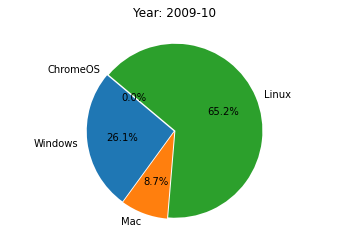

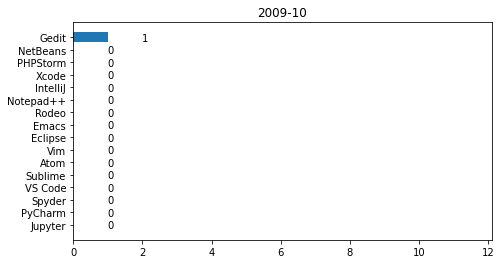

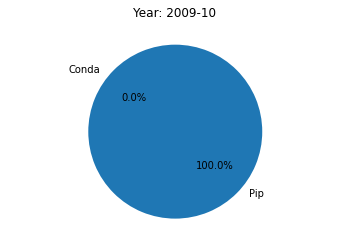

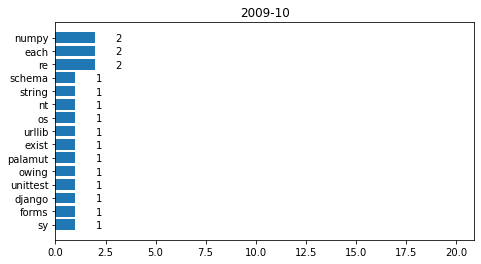

In [39]:
OSLabels = ['Windows', 'Mac', 'Linux', 'ChromeOS']
IDELabels = ["Jupyter", "PyCharm",  "Spyder", "VS Code", "Sublime", "Atom", "Vim", 
             "Eclipse", "Emacs", "Gedit", "Rodeo", "Notepad++", "IntelliJ",
             "Xcode", "PHPStorm", "NetBeans"]
PMLabels = ["Pip","Conda"]

createAnimatedPieChart(OSLabels,OSPieInput)       #Animations do NOT work in Jupyter Notebook, please run in a .py file..
createAnimatedBarPlot(IDELabels,IDEPieInput)
createAnimatedPieChart(PMLabels,PMPieInput)
createAnimatedBarPlot(libraryLabelsList,libraryBarInput)

In [40]:
import numpy as np

def getCoordinatesFromDict(data_labels,data_dict):
    '''
    Gets coordinates for plotting using animated data
    '''
    plotData = []
    for i in range(len(data_labels)):
        iter = 0
        points = []
        for key in data_dict.keys():
            if (iter > 96):             #Blocks off incomplete month due to end of data
                break
            points.append([iter,data_dict[key][i]])
            iter +=1
        plotData.append(points)
    return plotData


def plotLineGraph(data_list, labels, title, keep = [], custom = False):
    '''
    Plots line graph based on given coordinates and writes string x labels
    for corresponding year
    '''
    fig, ax = plt.subplots()
    plt.title(title, **font)
    for i in range(len(data_list)):
        if custom:
            if labels[i] not in keep:
                continue
        data = np.array(data_list[i])
        x,y = data.T 
        x_labels = ['']*len(x)
        if len(x)>= 5:  x_labels[5]  = '2009'
        if len(x)>= 17: x_labels[17] = '2010'
        if len(x)>= 29: x_labels[29] = '2011'
        if len(x)>= 41: x_labels[41] = '2012'
        if len(x)>= 53: x_labels[53] = '2013'
        if len(x)>= 65: x_labels[65] = '2014'
        if len(x)>= 77: x_labels[77] = '2015'
        if len(x)>= 89: x_labels[89] = '2016'
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.xlabel("Year",**font)
        plt.ylabel("Count",**font)
        plt.xticks(range(len(x_labels)), x_labels, size='small',**font)  #Labels corresponding to years
        plt.plot(x,y, label= labels[i],color = tableau10light[i])   #Shows labels of line
        plt.legend()   #Adds legend
        plt.rcParams.update({'font.family':'Nunito'})
    plt.show()

In [41]:
import numpy as np

def getCoordinatesFromDict(data_labels,data_dict):
    '''
    Gets coordinates for plotting using animated data
    '''
    assert isinstance(data_labels,list)
    assert isinstance(data_dict,OrderedDict)
    plotData = []
    for i in range(len(data_labels)):
        iter = 0
        points = []
        for key in data_dict.keys():
            if (iter > 96):             #Blocks off incomplete month due to end of data
                break
            points.append([iter,data_dict[key][i]])
            iter +=1
        plotData.append(points)
    return plotData


def plotLineGraph(data_list, labels, title, keep = [], custom = False):
    '''
    Plots line graph based on given coordinates and writes string x labels
    for corresponding year
    '''
    assert isinstance(data_list,list)
    assert isinstance(labels,list)
    assert isinstance(title,str)
    assert isinstance(custom,bool)
    plt.title(title)
    for i in range(len(data_list)):
        if custom:
            if labels[i] not in keep:
                continue
        data = np.array(data_list[i])
        x,y = data.T 
        x_labels = ['']*len(x)   #Label indexes dependent on data length...
        if len(x)>= 5:  x_labels[5]  = '2009'
        if len(x)>= 17: x_labels[17] = '2010'
        if len(x)>= 29: x_labels[29] = '2011'
        if len(x)>= 41: x_labels[41] = '2012'
        if len(x)>= 53: x_labels[53] = '2013'
        if len(x)>= 65: x_labels[65] = '2014'
        if len(x)>= 77: x_labels[77] = '2015'
        if len(x)>= 89: x_labels[89] = '2016'
        plt.xticks(range(len(x_labels)), x_labels, size='small')  #Labels corresponding to years
        plt.plot(x,y, label= labels[i])   #Shows labels of line
        plt.legend()   #Adds legend
    plt.show()

OrderedDict([('2008-08', [11, 7, 14, 0]), ('2008-09', [41, 33, 58, 0]), ('2008-10', [48, 38, 73, 0]), ('2008-11', [38, 21, 63, 0]), ('2008-12', [27, 21, 44, 0]), ('2009-01', [48, 34, 76, 0]), ('2009-02', [54, 34, 70, 0]), ('2009-03', [45, 39, 91, 0]), ('2009-04', [57, 32, 95, 0]), ('2009-05', [76, 59, 112, 0]), ('2009-06', [75, 56, 124, 0]), ('2009-07', [97, 54, 144, 0]), ('2009-08', [82, 65, 139, 0]), ('2009-09', [81, 74, 142, 1]), ('2009-10', [6, 2, 15, 0])])


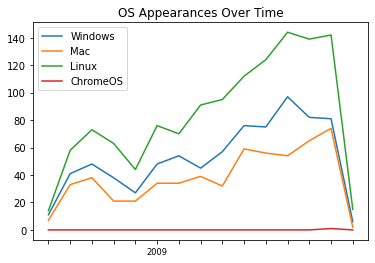

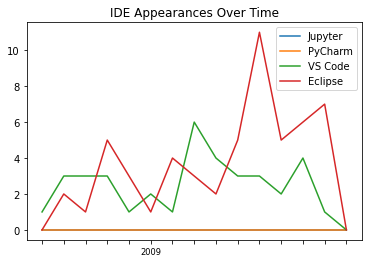

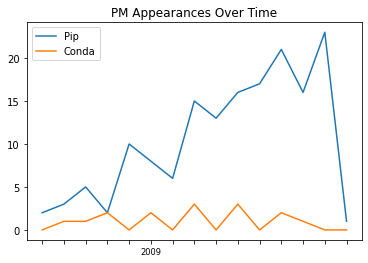

In [42]:
print(OSPieInput)

OSplotData = getCoordinatesFromDict(OSLabels,OSPieInput)
plotLineGraph(OSplotData, OSLabels, "OS Appearances Over Time")

IDEplotData = getCoordinatesFromDict(IDELabels,IDEPieInput)
plotLineGraph(IDEplotData, IDELabels, "IDE Appearances Over Time", ["PyCharm", "Jupyter", "Eclipse", "VS Code"], True)

PMplotData = getCoordinatesFromDict(PMLabels,PMPieInput)
plotLineGraph(PMplotData, PMLabels, "PM Appearances Over Time")

In [43]:
def reformatLibraryDict(libraryLabelsList, libraryBarInput, newLabels):
    '''
    Format most common library data for plotting 
    (Stored differently due to different algorithm used)
    '''
    libraryDict = OrderedDict()
    LibPlotLabels = []
    LibPlotData = []
    for i in range(len(libraryLabelsList)):
        index = 0
        added = []
        for label in libraryLabelsList[i]:         #If the input newLabels match any of the top 15 labels per given year-month
            for newlabel in newLabels:
                if newlabel == label:
                    if newlabel not in libraryDict.keys():
                        libraryDict[newlabel] = []
                    libraryDict[newlabel].append(list(libraryBarInput.items())[i][1][index])
                    added.append(newlabel)
            index +=1
        for newlabel in newLabels:                #Appends last value into plot data for newLabel if not present in labels
            if newlabel not in added:
                if newlabel not in libraryDict.keys():
                        libraryDict[newlabel] = [0]
                else:
                    libraryDict[newlabel].append(libraryDict[newlabel][-1])
    for key in libraryDict.keys():
        LibPlotLabels.append(key)
        temp = []
        index = 0
        for data in libraryDict[key]:
            if (index > 96):             #Blocks off incomplete month due to end of data
                break
            temp.append([index, libraryDict[key][index]])   #Formats data for plotting
            index +=1 
        LibPlotData.append(temp)
    return LibPlotLabels, LibPlotData

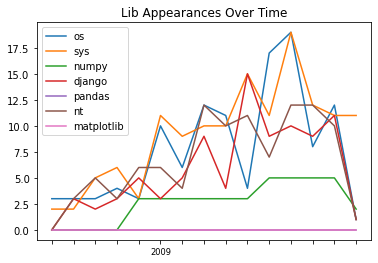

In [44]:
LibNewLabels = ["numpy", "sys", "os", "django", "pandas", "nt", "matplotlib"]
LibPlotLabels, LibPlotData = reformatLibraryDict(libraryLabelsList, libraryBarInput, LibNewLabels)
plotLineGraph(LibPlotData, LibPlotLabels, "Lib Appearances Over Time")

In [45]:
def plotTopicSummaryChart():
        '''
        This function will output a donut chart with percentages indiciating how frequent a topic was of a certain
        topic based on the LDA algorithm. 
        '''
        font = {'fontname':'Nunito'}
        colors = [(174/255, 199/255, 232/255),(255/255, 187/255, 120/255), (255/255, 152/255, 150/255),(247/255, 182/255, 210/255), (219/255, 219/255, 141/255),(152/255, 223/255, 138/255), (199/255, 199/255, 199/255), (196/255, 156/255, 148/255), (158/255, 218/255, 229/255), (197/255, 176/255, 213/255), (255/255, 200/255, 186/255)]
        blueColor = (174/255, 199/255, 232/255)
        grayColor = (197/255, 176/255, 213/255)
        topics = ["Basics", "Functions/Classes/OOP", "Specific Modules/Libraries", "File I/O", 
                "Data Manipulation/Handling" , "Web Applications/Frameworks", "Other", "Data Visualization",
                "Setup", "GUI Programming", "Error/Exception Handling"]
        values = [13,12,12,10,9,8,6,5,3,3,3]
        fig, ax = plt.subplots(figsize=(24, 12), subplot_kw=dict(aspect="equal"))
        ax.set_title("Topic Frequency in Stack Overflow", **font)
        wedges, texts, percent = ax.pie(values,  autopct='%1.1f%%', pctdistance=.4, wedgeprops=dict(width=0.5), startangle=40, colors = colors)
        plt.rcParams.update({'font.family':'Nunito'})
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"),
                bbox=bbox_props, zorder=0, va="center")
        for i, p in enumerate(wedges):  
                ang = (p.theta2 - p.theta1)/2. + p.theta1
                y = np.sin(np.deg2rad(ang))
                x = np.cos(np.deg2rad(ang))
                horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
                connectionstyle = "angle,angleA=0,angleB={}".format(ang)
                kw["arrowprops"].update({"connectionstyle": connectionstyle})
                ax.annotate(topics[i], xy=(x, y), xytext=(1.2*np.sign(x), 1.1*y),
                                horizontalalignment=horizontalalignment, **kw, **font)
        plt.show()

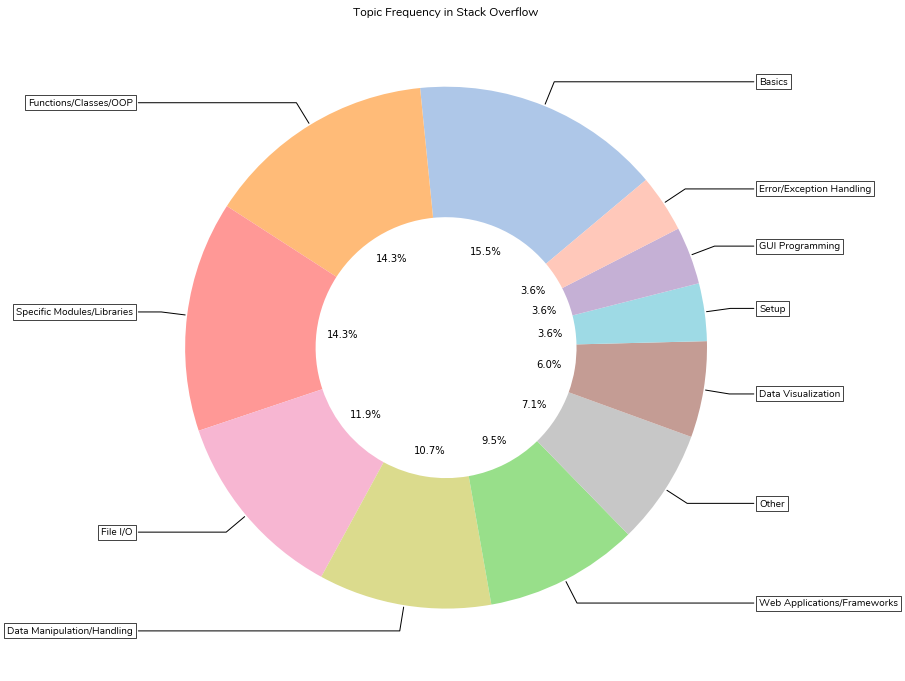

In [46]:
plotTopicSummaryChart() #Plots LDA summary

In [59]:
from io import StringIO
from html.parser import HTMLParser

import pandas as pd
import gensim
import numpy as np
import scipy
import pickle as pickle
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager

In [49]:
class StackOverflowParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.strict = False  # If any invalid html is encountered, parser will make a best guess at its intention
        self.convert_charrefs = True  # Hold data section until next tag is encountered

        # Field variable to keep track of parsed data with tags removed
        self.text = StringIO()
        self.text_no_code = StringIO()

        # Field variables to keep track of and store <code></code> blocks
        self.code_blocks = []
        self.lasttag = None

    def handle_starttag(self, tag, attrs):
        '''
        Method inherited from HTMLParser super class that is called whenever the start of a tag is encountered.
        In this parser, it keeps track of the last start tag that was encountered.
        :param tag: Current tag being parsed (ex: p, div, code, etc.)
        :type tag: str
        :param attrs: List of (name,value) pairs containing attributes found inside the tag's brackets
        :type attrs: list[str]
        '''
        assert isinstance(tag, str)
        assert isinstance(attrs, list)

        self.lasttag = tag

    def handle_data(self, data):
        '''
        Method inherited from HTMLParser super class that is called whenever data inside of a tag is encountered.
        In this parser, it saves blocks of code to the field variable self.code and records all text with HTML tags removed
        :param data: Current data inside of a tag being parsed
        :type tag: str
        '''
        assert isinstance(data, str)

        # If the last tag encountered was a <code> tag, append the contents to the list of code blocks
        if self.lasttag == "code":
            self.lasttag = None
            self.code_blocks.append(data)
        else:
            self.text_no_code.write(data)

        # Record text between tags
        self.text.write(data)

    def get_data(self):
        '''
        Returns parsed text without HTML tags
        :return: Text wihtout tags
        :type return: str
        '''
        return self.text.getvalue()

    def get_data_no_code(self):
        '''
        Returns parsed text without HTML tags and with code blocks removed
        :return: Text wihtout tags
        :type return: str
        '''
        return self.text_no_code.getvalue()


def strip_tags(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the same text with the HTML tags now removed.
    This method bundles the process of instantiating a parser, feeding the data, and returning the parsed output.
    :param html: HTML-formatted body of text
    :type html: str
    :return: The input text now without HTML tags
    :type return: str
    '''
    assert isinstance(html, str)

    # Feed text into parser and return parsed text without tags
    s = StackOverflowParser()
    s.feed(html)
    return s.get_data()


def get_text_no_code(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the same text with the HTML tags and blocks of code now removed.
    This method bundles the process of instantiating a parser, feeding the data, and returning the parsed output.
    :param html: HTML-formatted body of text
    :type html: str
    :return: The input text now without HTML tags or code blocks
    :type return: str
    '''
    assert isinstance(html, str)

    # Feed text into parser and return parsed text without tags
    s = StackOverflowParser()
    s.feed(html)
    return s.get_data_no_code()


def get_code(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the blocks of code found within the text.
    This method bundles the process of instantiating a parser, feeding the data, and returning the blocks of code.
    An empty list is returned if no <code> tags are found.
    :param html: HTML-formatted body of text
    :type html: str
    :return: List of blocks of code found within text
    :type return: list[str]
    '''
    assert isinstance(html, str)

    s = StackOverflowParser()
    s.feed(html)
    return [item.replace('\n', ' ') for item in s.code_blocks]


# import pandas as pd

# File paths
file_questions = 'Questions.csv'
file_answers = 'Answers.csv'
file_tags = 'Tags.csv'

dates = ["CreationDate"]



# # Load dataframes (only loading first 10000 rows for now to reduce processing time)
# questions_df = pd.read_csv(file_questions, nrows=1000, encoding='iso-8859-1')
# answers_df = pd.read_csv(file_answers, nrows=1000, encoding='iso-8859-1')
questions_df = pd.read_csv(file_questions, encoding='iso-8859-1', nrows=10000)
answers_df = pd.read_csv(file_answers, encoding='iso-8859-1', nrows=10000)
# tags_df = pd.read_csv(file_tags, encoding = 'iso-8859-1', nrows=10000)
# In[ ]:


# Add extra columns to dataframes
# This takes a long time (~10 minutes) to process the entire dataset
# Might be worth exploring the pandas to_pickle() method for saving/loading the dataframes
# questions_df['Body_no_tags'] = questions_df['Body'].apply(strip_tags)
questions_df['Body_no_tags_no_code'] = questions_df['Body'].apply(get_text_no_code)
# questions_df['Body_code'] = questions_df['Body'].apply(get_code)

# answers_df['Body_no_tags'] = answers_df['Body'].apply(strip_tags)
answers_df['Body_no_tags_no_code'] = answers_df['Body'].apply(get_text_no_code)
# answers_df['Body_code'] = answers_df['Body'].apply(get_code)


# Row 11 in Questions.csv is a good example with a few code blocks
# body = questions_df['Body'][11]
# body_no_tags = questions_df['Body_no_tags'][11]
# body_code = questions_df['Body_code'][11]
# body_no_tags_no_code = questions_df['Body_no_tags_no_code'][11]
questions = questions_df['Body_no_tags_no_code']
answers = answers_df['Body_no_tags_no_code']

In [50]:
from textblob import TextBlob

def sentiment_analysis(comment):
    '''
    This function calculate the polarities of each strings from the preprocessed questions/answers strings and store
    them into a dictionary.
    :param comment:
    :return:
    '''
    dict_sentiment = {}
    for feedback in range(len(comment)):
        pol = TextBlob(comment[feedback]).sentiment.polarity
        dict_sentiment[feedback] = pol

    return dict_sentiment

In [51]:
question_dict = sentiment_analysis(questions)
answer_dict = sentiment_analysis(answers)

In [52]:
def find_polarities(adict):
    pos_dict = {}
    neu_dict = {}
    neg_dict = {}
    for key, values in adict.items():
        if values > 0:
            pos_dict[key] = values
        elif values == 0:
            neu_dict[key] = values
        else:
            neg_dict[key] = values

    return pos_dict, neu_dict, neg_dict

In [53]:
q_pos, q_neu, q_neg = find_polarities(question_dict)
a_pos, a_neu, a_neg = find_polarities(answer_dict)

In [54]:
def find_general_tone(adict):
    all_val = adict.values()
    max_val = max(all_val)
    min_val = min(all_val)

    avg = sum(adict.values()) / len(adict)

    return max_val, min_val, avg

In [55]:
find_general_tone(question_dict)

(1.0, -1.0, 0.09950502793391741)

In [56]:
def plot_sentiment_overall():
    q_max, q_min, q_avg = find_general_tone(question_dict)
    a_max, a_min, a_avg = find_general_tone(answer_dict)
    w = 0.2
    bar1 = np.arange(1)
    bar2 = bar1 + w
    bar3 = bar2 + w
    font = {'fontname': 'Nunito'}
    plt.subplot(1,2,1)

    # plt.bar(bar, [q_max, q_min, q_avg], w, label='Most Positive Polarity')
    plt.bar(bar1, q_max, w, color=(152/255, 223/255, 138/255), label='Most Positive Polarity')
    plt.bar(bar2, q_min, w, color=(255/255, 152/255, 150/255), label='Most Negative Polarity')
    plt.bar(bar3, q_avg, w, color=(158/255, 218/255, 229/255), label='Average Polarity')

    # plt.rcParams['font.family'] = 'Nunito'
    plt.title('Questions', fontsize=16, **font)
    plt.ylabel('Polarity', fontsize=16, **font)
    plt.xticks([], [])
    plt.legend(prop={'family': 'Nunito', 'size':15})
    plt.rcParams.update({'font.family': 'Nunito'})
    # plt.show()

    plt.subplot(1,2,2)
    plt.bar(bar1, a_max, w, color=(152/255, 223/255, 138/255), label='Most Positive Polarity')
    plt.bar(bar2, a_min, w, color=(255/255, 152/255, 150/255), label='Most Negative Polarity')
    plt.bar(bar3, a_avg, w, color=(158/255, 218/255, 229/255), label='Average Polarity')
    plt.xticks([], [])

    plt.ylabel('Polarity', fontsize=16, **font)
    plt.title('Answers', fontsize=16, **font)
    # plt.bar(bar1, max_values, w, label='Most Positive Polarity')
    # plt.bar(bar2, min_values, w, label='Most Negative Polarity')
    # plt.bar(bar3, avg_values, w, label='Average Polarity')
    # plt.xticks(bar1+w, 'Questions')

    plt.legend(prop={'family': 'Nunito', 'size':15})
    plt.rcParams.update({'font.family': 'Nunito'})
    #
    plt.show()

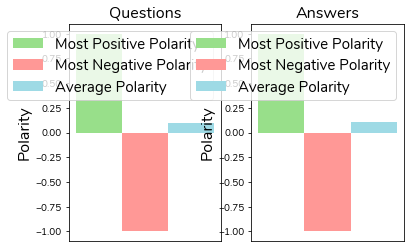

                                                                                                                                             Terms per Topic
Topic1    list, element, generator, object, would, set, value, iterator, create, item, return, function, work, code, time, case, make, method, change, get  
Topic2    flask, number, would, get, application, user, function, create, find, vector, code, service, file, web, time, work, matrix, may, could, object    
Topic3    cookie, function, root, would, file, work, set, find, time, get, code, list, run, make, see, send, create, may, take, thread                      
Topic4    address, function, list, code, file, script, get, would, value, check, find, run, program, number, create, call, output, add, user, return        
Topic5    function, code, call, time, make, value, scope, work, run, return, get, would, name, change, could, take, define, case, array, variable           
...                                                       

<ipython-input-60-a442b5161b1e>:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [60]:
plot_sentiment_overall()


ldamulticore = pickle.load(open("ldamulticore_100_QA.pkl", "rb"))
# pprint(ldamulticore.show_topics(num_words=5,formatted=False))
topics = [[(term, round(wt, 3)) for term, wt in ldamulticore.show_topic(n, topn=20)] for n in range(0, ldamulticore.num_topics)]

pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns=['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamulticore.num_topics+1)])

print(topics_df)
topics_split = topics_df['Terms per Topic'].str.split(',')

{'Topic1': 0.10871915681916874, 'Topic2': 0.1097401376738993, 'Topic3': 0.10858460698895733, 'Topic4': 0.1067976747692149, 'Topic5': 0.10696009939215849, 'Topic6': 0.10912824903510325, 'Topic7': 0.10635942413234517, 'Topic8': 0.10547520185153228, 'Topic9': 0.10670978947015575, 'Topic10': 0.1091371625518273, 'Topic11': 0.10702071677135441, 'Topic12': 0.10819687898392377, 'Topic13': 0.10554878432194645, 'Topic14': 0.10657749348056939, 'Topic15': 0.10790223454640072, 'Topic16': 0.10694636855730288, 'Topic17': 0.1077216270656739, 'Topic18': 0.10943484919377446, 'Topic19': 0.11030115609645398, 'Topic20': 0.10751442801046313, 'Topic21': 0.11282543002019568, 'Topic22': 0.10727951539301551, 'Topic23': 0.10823818358086967, 'Topic24': 0.10581088959012547, 'Topic25': 0.1102223803608961, 'Topic26': 0.108439810920823, 'Topic27': 0.1081214231639235, 'Topic28': 0.10584390370354933, 'Topic29': 0.11006045413286718, 'Topic30': 0.10817234834239225, 'Topic31': 0.1059215834196717, 'Topic32': 0.105253585411

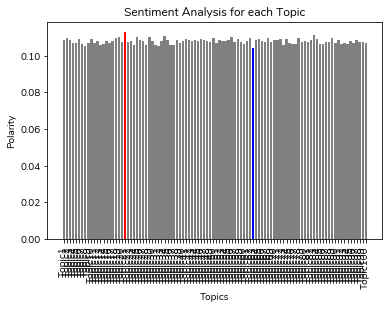

In [61]:
def getsentiment_topics(x):
    '''
    This function checks if any word in each topic word list also exists in the strings of the questions/answers.
    If so, calculate the polarity of that string and get the average polarity for all the topics.
    The function should return a dictionary where keys are Topic1-100 and values are the average polarities of the
    corresponding topics.
    '''
    topic_dict = {}
    for i in range(len(topics_split)):
        count = 0
        pol = 0
        word_list = [word.strip() for word in topics_split[i]]
        for q in x:
            q_split = q.split()
            check = any(item in q_split for item in word_list)
            if check:
                count += 1
                pol += TextBlob(q).sentiment.polarity
        if count != 0:
            avg_pol = pol / count
            topic_dict['Topic' + str(i+1)] = avg_pol
        else:
            topic_dict['Topic' + str(i+1)] = 0
    return topic_dict


topic_dict_question = getsentiment_topics(questions)
topic_dict_answers = getsentiment_topics(answers)

def merge_dict(x, y):
    keys = x.keys()
    values = zip(x.values(), y.values())
    combined = dict(zip(keys, values))
    avgdict = {}
    for keys, values in combined.items():
        avgdict[keys] = (values[0] + values[1]) / 2

    return avgdict

avg_dict = merge_dict(topic_dict_question, topic_dict_answers)
print(avg_dict)

keys = avg_dict.keys()
values = avg_dict.values()
clrs = ['red' if (x == max(values)) else 'blue' if (x == min(values)) else 'gray' for x in values]
plt.bar(keys, values, color=clrs)
plt.xlabel('Topics')
plt.ylabel('Polarity')
plt.title('Sentiment Analysis for each Topic')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# print(q_pos)


# import operator
# qmax = max(a_pos.items(), key=operator.itemgetter(1))[0]
# qmin = min(a_neg.items(), key=operator.itemgetter(1))[0]
#
# print(qmax, qmin)

#
# print(len(q_pos), len(q_neu), len(q_neg))
# print(len(a_pos), len(a_neu), len(a_neg))